# Latent diffusion model for generating ensembl members

This notebook contains information for the design, hyperparameters, and training of a LDM that generates ensemble members from the bias-corrected ensemble mean.

In [1]:
import os
import sys
import time
import math
import h5py
import logging
import warnings
import numpy as np
from glob import glob

# supress regular warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# supress tensorflow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# adjust for time step embedding layer
tf.config.run_functions_eagerly(True)

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu
import verif_utils as vu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mu.set_seeds(888)

## Import VQ-VAE decoder

In [5]:
# Hyperparameters
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 4 # number of latent feature channels
activation = 'gelu' # activation function
num_embeddings = 128 #128 # number of the VQ codes

input_size = (224, 464, 1) # size of MRMS input
latent_size = (14, 29, latent_dim) # size of compressed latent features

drop_encode = False
drop_decode = False

model_name_encoder_load = model_dir+'models/VQ_VAE_encoder_stack1_tune0'
model_name_decoder_load = model_dir+'models/VQ_VAE_decoder_stack1_tune0'

encoder = mu.VQ_VAE_encoder(input_size, filter_nums, latent_dim, num_embeddings, activation, drop_encode)
W_old = mu.dummy_loader(model_name_encoder_load)
encoder.set_weights(W_old)

decoder = mu.VQ_VAE_decoder(latent_size, filter_nums, activation, drop_decode)
W_old = mu.dummy_loader(model_name_decoder_load)
decoder.set_weights(W_old)

## LDM config

In [6]:
# diffusion steps
diffusion_steps = 100

In [7]:
# min-max values
ccpa_min = -2.0606
ccpa_max = 1.6031

LEADs = np.arange(6, 144+6, 6) # forecast lead times
N_leads = len(LEADs)

# The tensor size of embedded CCPA and GEFS ensemble mean 
latent_size = (14, 29, 4)
input_size = (N_leads,) + latent_size

# model design
widths = [32, 64, 96, 128]
embedding_dims = 32
block_depth = 2

min_signal_rate = 0.02
max_signal_rate = 0.95
ema = 0.999

load_weights = True
# location of the previous weights
model_name_load = model_dir+'baseline/LDM_step{:02d}_base/'.format(diffusion_steps)

# location for saving new weights
model_name_save = model_dir+'baseline/LDM_step{:02d}_base/'.format(diffusion_steps)

epochs = 99999
N_batch = 2
batch_size_ = 64
batch_size = batch_size_*32
lr = 1e-4

In [22]:
def rescale(x, min_val=ccpa_min, max_val=ccpa_max):
    return ((x - min_val) / (max_val - min_val))* 2 - 1

def scaleback(x, min_val=ccpa_min, max_val=ccpa_max):
    return 0.5*(x+1)*(max_val-min_val) + min_val

def to_precip(x):
    x[x<0] = 0
    return 10*(np.exp(x) - 1)

def valid_func(valid_true_CCPA, decoder, LDM, valid_ViT, land_mask_CCPA):
    L_valid, N_leads, EN, _, _, _ = valid_ViT.shape
    
    Y_pred_ViT = np.empty((L_valid, N_leads, EN, 224, 464))
    
    for ien in range(EN):
        y_pred_vit = LDM.generate(L_valid, valid_ViT[:, :, ien, ...])
        y_pred_vit = scaleback(np.array(y_pred_vit))
        
        for ilead in range(N_leads):
            Y_pred_ViT[:, ilead, ien, ...] = decoder.predict(y_pred_vit[:, ilead, ...], verbose=0)[..., 0]

    Y_pred_ViT = to_precip(Y_pred_ViT)
    Y_pred_ViT[Y_pred_ViT<0] = 0
    
    CRPS = np.empty((L_valid, N_leads, 224, 464)); CRPS[...] = np.nan
    
    for ilead in range(N_leads):
    
        crps_ilead, _, _ = vu.CRPS_2d(valid_true_CCPA[:, ilead, ...], 
                                      Y_pred_ViT[:, ilead, ...], land_mask=land_mask_CCPA)
        CRPS[:, ilead, ...] = crps_ilead

    return np.nanmean(CRPS)
    
def base_func(valid_true_CCPA, decoder, valid_ViT, land_mask_CCPA):
    L_valid, N_leads, EN, _, _, _ = valid_ViT.shape
    
    Y_pred_ViT = np.empty((L_valid, N_leads, EN, 224, 464))
    
    for ien in range(EN):        
        for ilead in range(N_leads):
            Y_pred_ViT[:, ilead, ien, ...] = decoder.predict(valid_ViT[:, ilead, ien, ...], verbose=0)[..., 0]

    Y_pred_ViT = to_precip(Y_pred_ViT)
    Y_pred_ViT[Y_pred_ViT<0] = 0
    
    CRPS = np.empty((L_valid, N_leads, 224, 464)); CRPS[...] = np.nan
    
    for ilead in range(N_leads):
    
        crps_ilead, _, _ = vu.CRPS_2d(valid_true_CCPA[:, ilead, ...], 
                                      Y_pred_ViT[:, ilead, ...], land_mask=land_mask_CCPA)
        CRPS[:, ilead, ...] = crps_ilead

    return np.nanmean(CRPS)

## Prepare validation set

In [9]:
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    land_mask_CCPA = h5io['land_mask_CCPA'][...]
    
land_mask_CCPA = land_mask_CCPA == 1.0
ccpa_shape = land_mask_CCPA.shape

In [10]:
BATCH_dir = camp_dir+'BATCH_LDM_member_OPT/'
filenames = sorted(glob(BATCH_dir+'*npy'))

In [19]:
EN = 31

BATCH_dir = camp_dir+'BATCH_LDM_member_OPT/'
filenames = sorted(glob(BATCH_dir+'*npy'))

L_valid = 20
filenames_valid = filenames[::7][:L_valid]

valid_true_CCPA = np.empty((L_valid, N_leads,)+ccpa_shape)
valid_ViT = np.empty((L_valid, N_leads, EN)+latent_size)

for i, name_ in enumerate(filenames_valid):
    temp_data = np.load(name_, allow_pickle=True)[()]
    valid_true_CCPA[i, ...] = temp_data['CCPA_true'][:N_leads, ...]
    valid_ViT[i, ...] = temp_data['ViT_embed'][:N_leads, ...]
    
valid_ViT = rescale(valid_ViT)
valid_ViT = valid_ViT[:, :, :5, ...]

In [12]:
BATCH_dir = camp_dir+'BATCH_LDM_member/'
filename_train = sorted(glob(BATCH_dir+'*npy'))

# filename_train = list(set(filenames) - set(filenames_valid))
L_train = len(filename_train)

min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

In [1]:
decay_steps = batch_size/batch_size_
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=lr, 
                                                         decay_steps=decay_steps, 
                                                         alpha=0.1)

model= mu.DiffusionModel(input_size, input_size, input_size, 
                        diffusion_steps, min_signal_rate, max_signal_rate, 
                        embedding_dims, widths, block_depth, ema)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.AdamW(learning_rate=cosine_decay))

# load previous weights
if load_weights:
    model.load_weights(model_name_load)

batch_CCPA = np.empty((batch_size, N_leads,)+latent_size)
batch_CCPA[...] = np.nan

batch_ViT = np.empty((batch_size, N_leads,)+latent_size)
batch_ViT[...] = np.nan

for i in range(epochs):
    print('epoch = {}'.format(i))
    if i == 0:
        if load_weights:
            record = valid_func(valid_true_CCPA, decoder, model, valid_ViT, land_mask_CCPA)
        else:
            record = 999
        print('Initial validation loss: {}'.format(record))
        
    start_time = time.time()
    for j in range(N_batch):
        #start_time = time.time()
        inds_rnd = du.shuffle_ind(L_train)
        inds_ = inds_rnd[:batch_size]
        
        for k, ind in enumerate(inds_):
            # import batch data
            name_ = filename_train[ind]
            temp_data = np.load(name_, allow_pickle=True)[()]
            batch_CCPA[k, ...] = temp_data['CCPA_embed'][:N_leads, ...]
            batch_ViT[k, ...] = temp_data['ViT_embed'][:N_leads, ...]

        batch_CCPA = rescale(batch_CCPA)
        batch_ViT = rescale(batch_ViT)
        
        model.fit([batch_CCPA, batch_ViT], batch_size=batch_size_, epochs=1, verbose=0)
        #print("--- %s seconds ---" % (time.time() - start_time))
    # on epoch-end
    record_temp = valid_func(valid_true_CCPA, decoder, model, valid_ViT, land_mask_CCPA)
    
    # print out valid loss change
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        print("Save to {}".format(model_name_save))
        model.save_weights(model_name_save)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        
    print("--- %s seconds ---" % (time.time() - start_time))
    # mannual callbacks

## Predition tests

In [13]:
model = mu.DiffusionModel(input_size, input_size, input_size, 
                        diffusion_steps, min_signal_rate, max_signal_rate, 
                        embedding_dims, widths, block_depth, ema)
# load previous weights
model.load_weights(model_name_save);

In [23]:
valid_func(valid_true_CCPA, decoder, model, valid_ViT, land_mask_CCPA)

0.1048040653674857

In [24]:
base_func(valid_true_CCPA, decoder, valid_ViT, land_mask_CCPA)

0.10541903031870066

In [26]:
def inference_func(valid_true_CCPA, decoder, LDM, valid_ViT, land_mask_CCPA):
    L_valid, N_leads, EN, _, _, _ = valid_ViT.shape
    
    Y_pred_ViT = np.empty((L_valid, N_leads, EN, 224, 464))
    
    for ien in range(EN):
        y_pred_vit = LDM.generate(L_valid, valid_ViT[:, :, ien, ...])
        y_pred_vit = scaleback(np.array(y_pred_vit))
        
        for ilead in range(N_leads):
            Y_pred_ViT[:, ilead, ien, ...] = decoder.predict(y_pred_vit[:, ilead, ...], verbose=0)[..., 0]

    Y_pred_ViT = to_precip(Y_pred_ViT)
    Y_pred_ViT[Y_pred_ViT<0] = 0
    return Y_pred_ViT

In [27]:
examples = inference_func(valid_true_CCPA, decoder, model, valid_ViT, land_mask_CCPA)

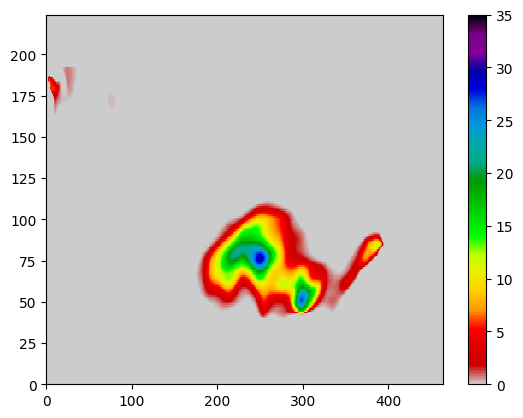

In [28]:
plt.pcolormesh(examples[0, 0, 4, ...], vmin=0, vmax=35, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()